In [8]:
import os
import sys
from importlib import reload
path = os.path.abspath(os.path.join('..'))
if path not in sys.path:
    sys.path.append(path)
        
from time import time 
import csv
import pickle

import numpy as np
import pandas as pd

import gb1
import utils

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.font_manager import FontProperties
import matplotlib as mpl
plt.rcParams["font.size"] = 14

import seaborn as sns
sns.set_style('white')

MODEL_PATH = '/data/wongfanc/gb1-models/'

# load results and plot

In [9]:
# load design distributions from both imputation and PP
temperatures = np.arange(0.2, 0.701, 0.005)
imptemp2theta = {
    round(temp, 4): np.load(MODEL_PATH + 'gb1-h10-10k-t{:.4f}-051324.npz'.format(temp))['theta_lxa']
    for temp in temperatures
}
imptemp2mean = gb1.get_true_mean_label_from_theta(imptemp2theta)

pptemp2theta = {
    round(temp, 4): np.load(MODEL_PATH + 'gb1-h10-5k-t{:.4f}-030123.npz'.format(temp))['theta_lxa']
    for temp in temperatures
}
pptemp2mean = gb1.get_true_mean_label_from_theta(pptemp2theta) 

In [10]:
# load PP selection results, computed in gb1-022823 nb
reload(utils)
target_values = np.arange(0.0, 1.51, 0.05)
n_pp_trial = 500
pp_results_csv_fname = '/data/wongfanc/gb1-results/gb1-ncal5000-042924.csv'

pp_df = pd.read_csv(pp_results_csv_fname, index_col=0)
ppworst_v, pperr_v, ppdisc_v, ppval2temprange = utils.process_gb1_selection_experiments(
    pp_df, target_values, temperatures, pptemp2mean, n_pp_trial, imp_or_pp='pp'
)

Processing pp results with 101 temperatures in [0.200, 0.700], 31 target values in [0.00, 1.50], 500 trials, and alpha = 0.1
Done processing (35 s)


In [12]:
# load imputation selection results, computed in gb1-imputation-051324.ipynb
reload(utils)
n_imp_trial = 10

imp_results_csv_fname = '/data/wongfanc/gb1-results/gb1-imp-010725.csv'
imp_df = pd.read_csv(imp_results_csv_fname, index_col=0)
impworst_v, imperr_v, impdisc_v, impval2temprange = utils.process_gb1_selection_experiments(
    imp_df, target_values, temperatures, imptemp2mean, n_imp_trial, imp_or_pp='imp'
)


Processing imp results with 101 temperatures in [0.200, 0.700], 31 target values in [0.00, 1.50], 10 trials, and alpha = 0.1
Done processing (0 s)


In [6]:
# load wheelock results
reload(utils)
gmm_csv_fname = '/data/wongfanc/gb1-results/gb1-wf-010725.csv'
qs = [0, 0.5, 1]
temp_names = ['temp{:.4f}'.format(round(temp, 4)) for temp in temperatures]
imp_name2truemeans = {
    'temp{:.4f}'.format(round(temp, 4)): imptemp2mean[round(temp, 4)]
    for temp in temperatures
}

gmm_df = pd.read_csv(gmm_csv_fname, index_col=0)
gmm_type2results = utils.process_wheelock_selection_experiments(
    gmm_df, target_values, temp_names, imp_name2truemeans, n_imp_trial, qs=qs
)

In [13]:
# load marginally calibrated forecast results
n_mc_trial = 100
mc_results_csv_fname = '/data/wongfanc/gb1-results/gb1-qc-121724.csv'

mc_df = pd.read_csv(mc_results_csv_fname, index_col=0)
mcworst_v, mcerr_v, mcdisc_v = utils.process_gb1_cp_selection_experiments(
    mc_df, target_values, temperatures, pptemp2mean, n_mc_trial
)

In [19]:
# load CP results, computed in gb1-cp-110724.ipynb
reload(utils)

cp_results_csv_fname = '/data/wongfanc/gb1-results/gb1-cp-110724.csv'
cp_df = pd.read_csv(cp_results_csv_fname, index_col=0)
cpworst_v, cperr_v, cpdisc_v = utils.process_cp_selection_experiments(
    cp_df, target_values, temperatures, pptemp2mean, 100
)

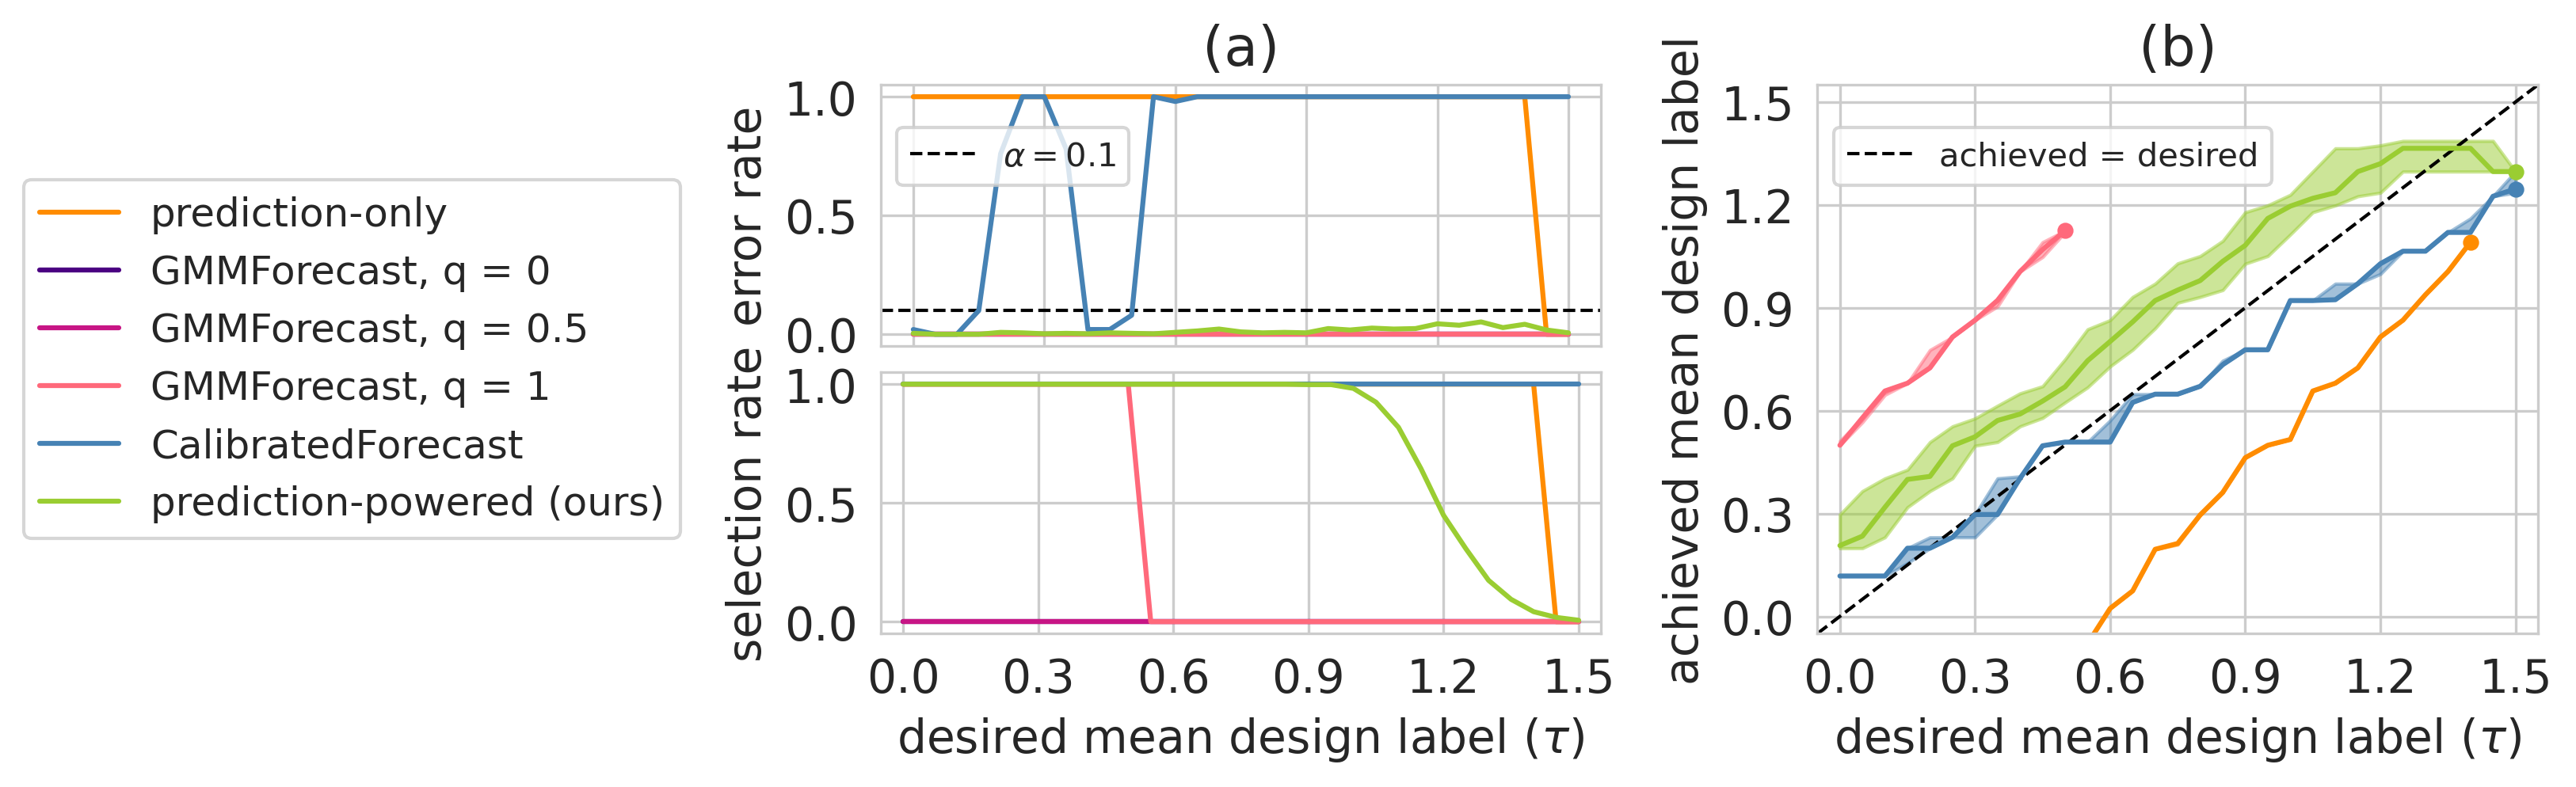

In [22]:
# one-row figure
sns.set_style('whitegrid')
fig = plt.figure(figsize=(9, 3), dpi=300)

gs = gridspec.GridSpec(1, 2, figure=fig)
gs0 = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=gs[0])

ax1 = fig.add_subplot(gs[1])
ax00 = fig.add_subplot(gs0[0])
ax10 = fig.add_subplot(gs0[1])

fig.subplots_adjust(wspace=0.3)
fig.subplots_adjust(hspace=0.1)


alpha = 0.1
gmm_type = 'cs'
imp_color = 'darkorange'
pp_color = 'yellowgreen'
gmm_colors = ['indigo', 'mediumvioletred', '#ff697b']
dark_line_color = 'k'

lw = 1.5
dark_lw = 1
legend_fs = 12
err_lim = [-0.05, 1.05]
err_ticks = [0, 0.5, 1]
tau_lim = [-0.05, 1.55]
tau_ticks = np.arange(0, 1.55, 0.3)
marker_sz = 15

q_low = 0.2
q_high = 0.8


# ===== subplot (a) =====

# ----- top (error) -----
ax00.axhline(alpha, linestyle='--', color=dark_line_color, alpha=1, linewidth=dark_lw, label=r'$\alpha = {}$'.format(alpha));

ax00.plot(target_values, imperr_v, c=imp_color, linewidth=lw);
for q_idx, q in enumerate(qs):
    _, gmmerr_v, gmmdisc_v, _ = gmm_type2results[gmm_type][q]
    ax00.plot(target_values, gmmerr_v, c=gmm_colors[q_idx], linewidth=lw);
ax00.plot(target_values, mcerr_v, c='steelblue', linewidth=lw);
ax00.plot(target_values, pperr_v, c=pp_color, linewidth=lw);

ax00.set_yticks(err_ticks)
# ax00.set_xlim(xlim)
ax00.set_ylim(err_lim)
ax00.set_xticks(tau_ticks)
ax00.set_xticklabels([])
ax00.set_ylabel('error rate');
ax00.set_title('(a)');

# dummy so get legend labels
ax00.legend(fontsize=10, loc='upper left', bbox_to_anchor=(0, 0.9));


# ----- bottom (selection rate) -----

ax10.plot(target_values, impdisc_v, '-', c=imp_color, linewidth=lw);
for q_idx, q in enumerate(qs):
    _, gmmerr_v, gmmdisc_v, _ = gmm_type2results[gmm_type][q]
    ax10.plot(target_values, gmmdisc_v, '-', c=gmm_colors[q_idx], linewidth=lw);
ax10.plot(target_values, mcdisc_v, '-', c='steelblue', linewidth=lw);
ax10.plot(target_values, ppdisc_v, '-', c=pp_color, linewidth=lw);

# dummy so get legend for (b)
ax10.plot([-1, -1], [-1, -1], '--', c=dark_line_color, linewidth=dark_lw, label='achieved = desired')
ax10.legend(fontsize=10, loc='upper left', bbox_to_anchor=(1.3, 2));

ax10.set_xlim(tau_lim)
ax10.set_ylim(err_lim)
ax10.set_xticks(tau_ticks)
ax10.set_yticks(err_ticks)
ax10.set_ylabel('selection rate');
ax10.set_xlabel(r'desired mean design label ($\tau$)');



# ===== subplot (b) =====

ax1.plot(tau_lim, tau_lim, '--', c=dark_line_color, alpha=1, linewidth=dark_lw);
median_v = [np.median(worst) if len(worst) else np.nan for worst in impworst_v]
ax1.plot(
    target_values, median_v,
    c=imp_color, label='prediction-only', linewidth=lw,
)
last_idx = np.where(np.isnan(median_v))[0][0] - 1
ax1.scatter(target_values[last_idx], median_v[last_idx], c=imp_color, s=marker_sz, alpha=1)
ax1.fill_between(
    target_values, [np.quantile(worst, q_low) if len(worst) else np.nan for worst in impworst_v],
    [np.quantile(worst, q_high) if len(worst) else np.nan for worst in impworst_v],
    color=imp_color, alpha=0.5,
)

for q_idx, q in enumerate(qs):
    gmmworst_v, _, _, _ = gmm_type2results[gmm_type][q]
    median_v = [np.median(worst) if len(worst) else np.nan for worst in gmmworst_v]
    ax1.plot(
        target_values, median_v,
        c=gmm_colors[q_idx], label=f'GMMForecast, q = {q}', linewidth=lw,
    )
    last_idx = np.where(np.isnan(median_v))[0][0] - 1
    ax1.scatter(target_values[last_idx], median_v[last_idx], c=gmm_colors[q_idx], s=marker_sz, alpha=1)
    ax1.fill_between(
        target_values, [np.quantile(worst, q_low) if len(worst) else np.nan for worst in gmmworst_v],
        [np.quantile(worst, q_high) if len(worst) else np.nan for worst in gmmworst_v],
        color=gmm_colors[q_idx], alpha=0.5,
    )

median_v = [np.median(worst) if len(worst) else np.nan for worst in mcworst_v]    
ax1.plot(
    target_values, median_v,
    c='steelblue', label='CalibratedForecast', linewidth=lw,
)
last_idx = -1
ax1.scatter(target_values[last_idx], median_v[last_idx], c='steelblue', s=marker_sz, alpha=1)
ax1.fill_between(
    target_values, [np.quantile(worst, q_low) if len(worst) else np.nan for worst in mcworst_v],
    [np.quantile(worst, q_high) if len(worst) else np.nan for worst in mcworst_v],
    color='steelblue', alpha=0.5,
)

median_v = [np.median(worst) if len(worst) else np.nan for worst in ppworst_v]
ax1.plot(
    target_values, median_v,
    c=pp_color, label='prediction-powered (ours)', linewidth=lw,
)
last_idx = -1
ax1.scatter(target_values[last_idx], median_v[last_idx], c=pp_color, s=marker_sz, alpha=1)
ax1.fill_between(
    target_values, [np.quantile(worst, q_low) if len(worst) else np.nan for worst in ppworst_v],
    [np.quantile(worst, q_high) if len(worst) else np.nan for worst in ppworst_v],
    color=pp_color, alpha=0.5,
)

ax1.set_xlim(tau_lim)
ax1.set_ylim(tau_lim)
ax1.set_xticks(tau_ticks)
ax1.set_yticks(tau_ticks)
# ax1.legend(fontsize=legend_f;s, loc='center left', bbox_to_anchor=(1.05, 0.5))
ax1.legend(fontsize=legend_fs, loc='center right', bbox_to_anchor=(-1.55, 0.5))

ax1.set_title('(b)')
ax1.set_ylabel('achieved mean design label');
ax1.set_xlabel(r'desired mean design label ($\tau$)');


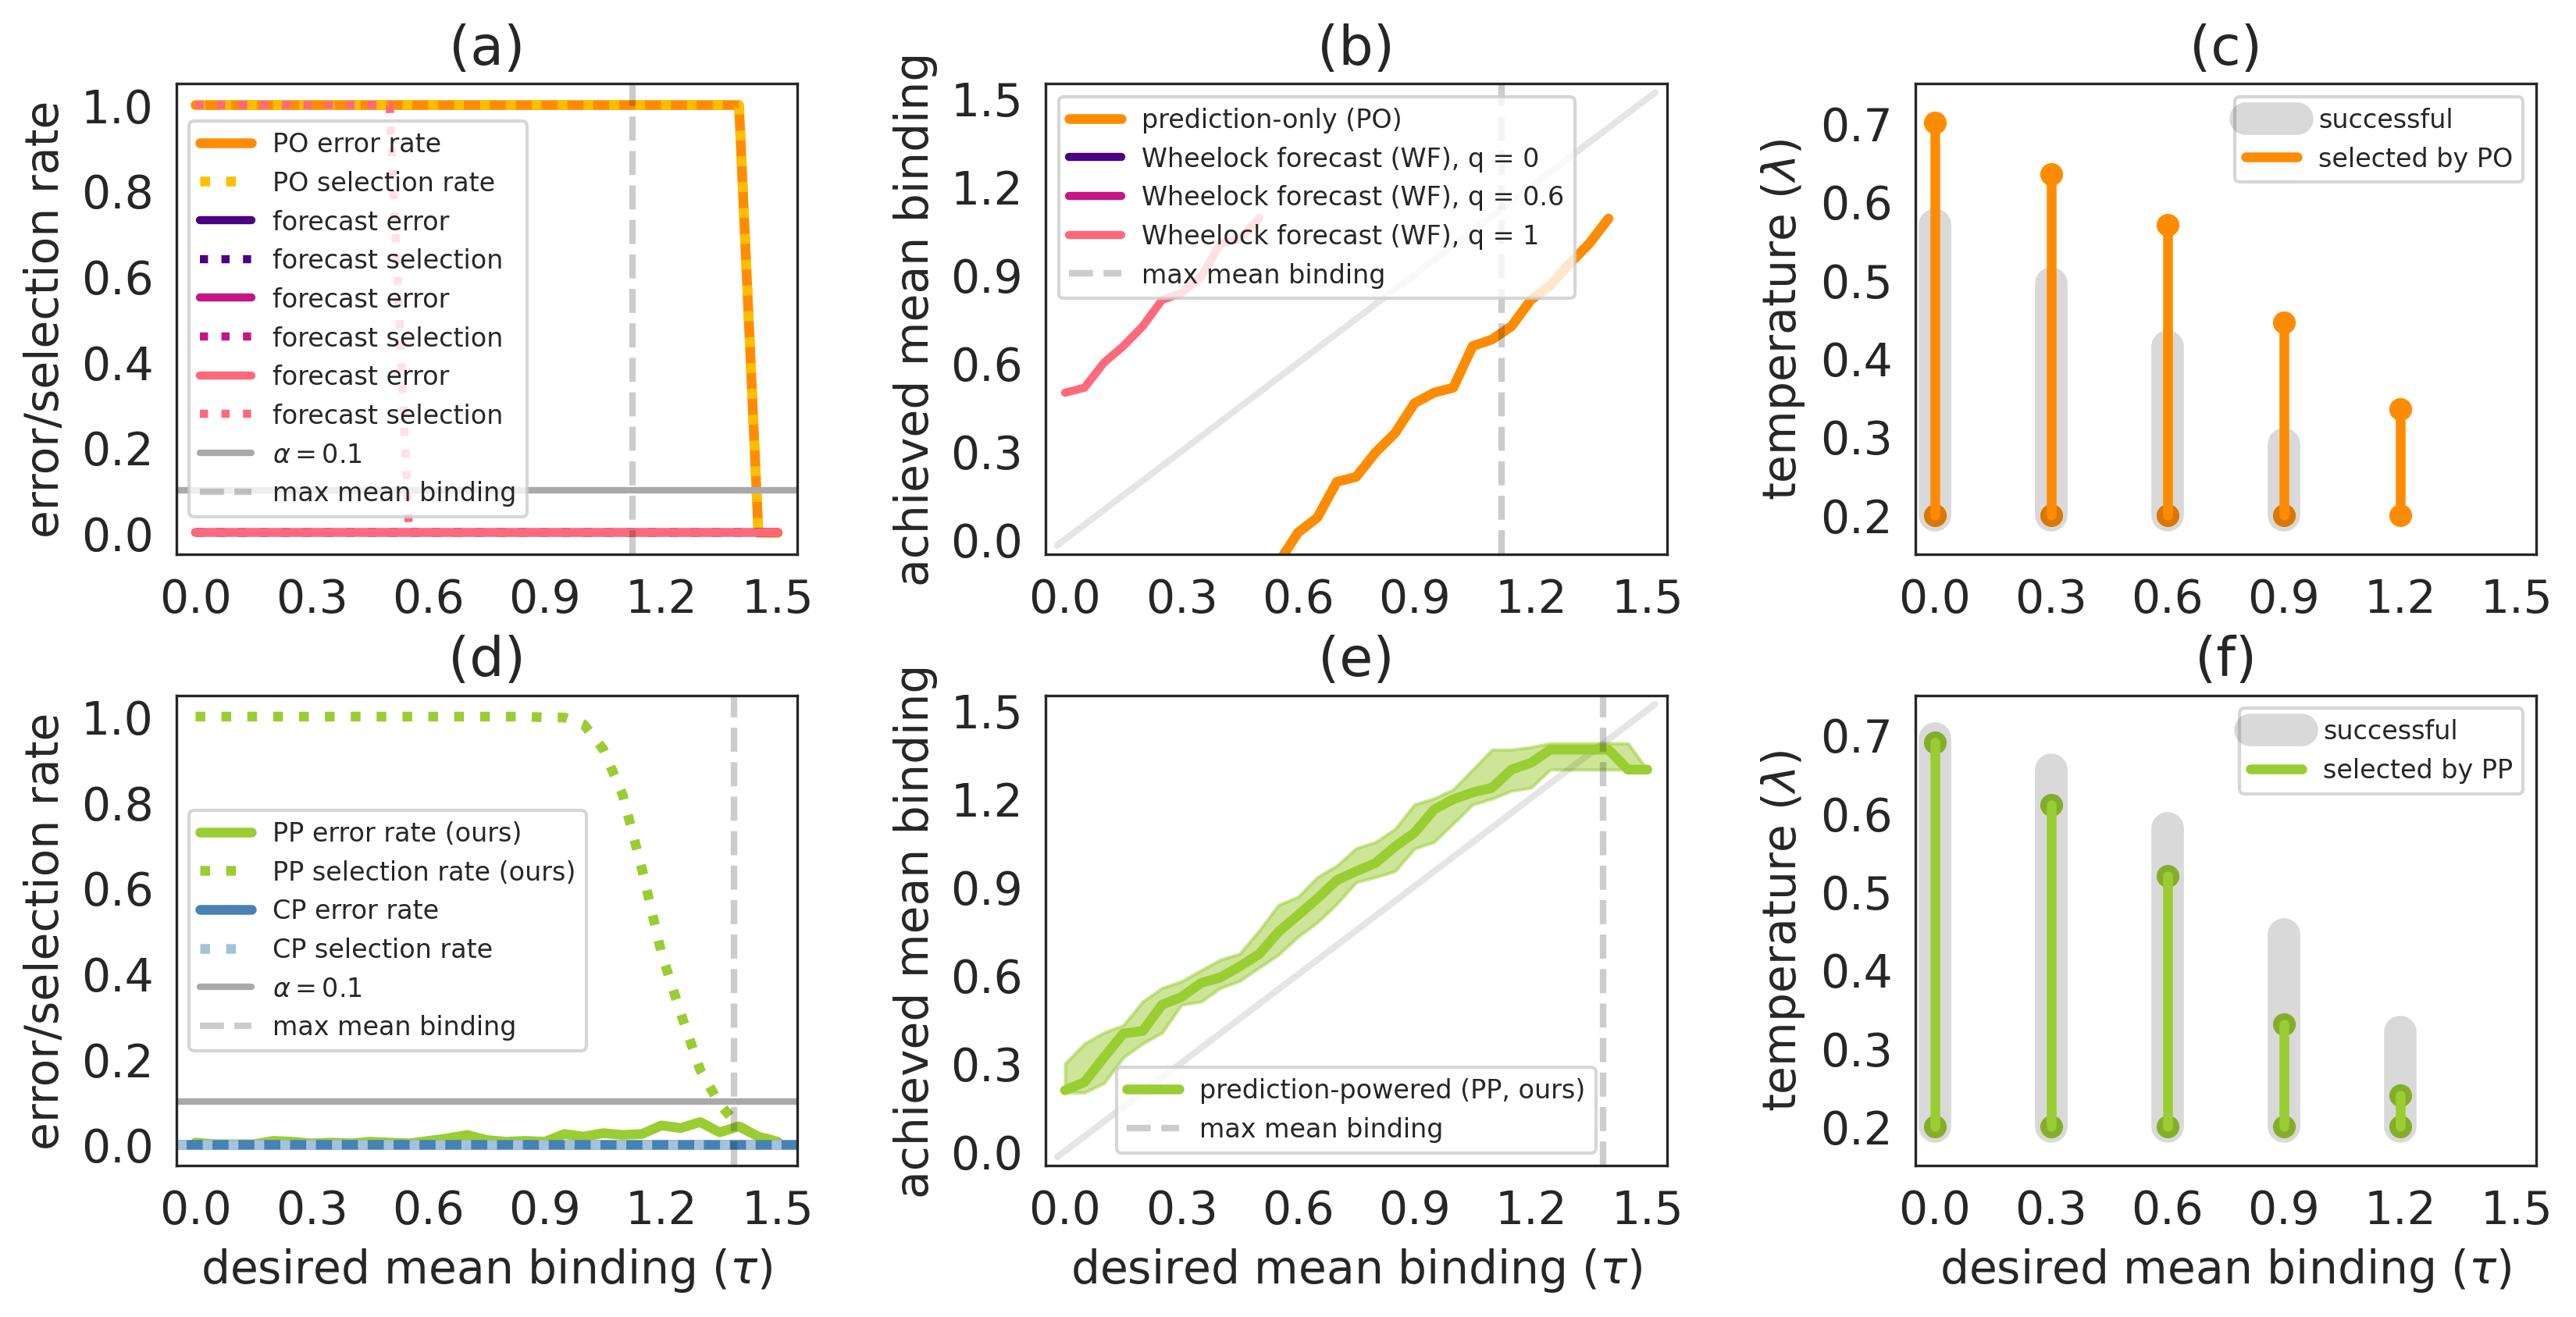

In [21]:
# plot two-row figure
fig, axs = plt.subplots(2, 3, figsize=(13, 6), dpi=300)
ax00 = axs[0, 0]
ax10 = axs[1, 0]
ax01 = axs[0, 1]
ax11 = axs[1, 1]
ax02 = axs[0, 2]
ax12 = axs[1, 2]
fig.subplots_adjust(wspace=0.4, hspace=0.3)

alpha = 0.1
wf_type = 'cs'
imp_color = 'darkorange'
pp_color = 'yellowgreen'
wf_colors = ['indigo', 'mediumvioletred', '#ff697b']
dark_line_color = 'darkgray'
lw = 2.5  # TODO: use throughout
imp_xlim = [-0.05, 1.55]
imp_xticks = np.arange(0, 1.55, 0.3)
pp_xlim = [-0.05, 1.55]
pp_xticks = np.arange(0, 1.55, 0.3)


imp_max_achievable = np.max(list(imptemp2mean.values()))
pp_max_achievable = np.max(list(pptemp2mean.values()))

# ===== subplots (a, d) =====

ax00.plot(target_values, imperr_v, c=imp_color, linewidth=3, label='PO error rate');
ax00.plot(target_values, impdisc_v, ':', c=(255/255, 191/255, 0), linewidth=3, label='PO selection rate');
for q_idx, q in enumerate(qs):
    _, wferr_v, wfdisc_v, _ = wf_type2results[wf_type][q]
    ax00.plot(target_values, wferr_v, c=wf_colors[q_idx], linewidth=lw, label='forecast error');
    ax00.plot(target_values, wfdisc_v, ':', c=wf_colors[q_idx], linewidth=lw, label='forecast selection');
    
ax00.axhline(alpha, linestyle='-', color=dark_line_color, alpha=1, linewidth=2, label=r'$\alpha = {}$'.format(alpha));
ax00.axvline(imp_max_achievable, linestyle='--', color='k', linewidth=2, alpha=0.2, label='max mean binding')
ax00.legend(fontsize=8)
ax00.set_ylabel('error/selection rate');
ax00.set_ylim([-0.05, 1.05])
ax00.set_yticks(np.arange(0, 1.05, 0.2))
ax00.set_xlim(imp_xlim)
ax00.set_xticks(imp_xticks)
ax00.set_title('(a)')

ax10.plot(target_values, pperr_v, c=pp_color, linewidth=3, label='PP error rate (ours)');
ax10.plot(target_values, ppdisc_v, ':', c=pp_color, linewidth=3, label='PP selection rate (ours)');
# ax10.plot(target_values, cperr_v, c='steelblue', linewidth=3, label='CP error rate');
# ax10.plot(target_values, cpdisc_v, ':', c='steelblue', linewidth=3, label='CP selection rate');
ax10.axhline(0, color='steelblue', linewidth=3, label='CP error rate');
ax10.axhline(0, color=(164/255, 195/255, 218/255), linestyle=':', linewidth=3, label='CP selection rate');
ax10.axhline(alpha, linestyle='-', color=dark_line_color, alpha=1, linewidth=2, label=r'$\alpha = {}$'.format(alpha));
ax10.axvline(pp_max_achievable, linestyle='--', color='k', linewidth=2, alpha=0.2, label='max mean binding')
ax10.legend(fontsize=8)
ax10.set_ylabel('error/selection rate');
ax10.set_xlabel(r'desired mean binding ($\tau$)');
ax10.set_ylim([-0.05, 1.05])
ax10.set_yticks(np.arange(0, 1.05, 0.2))
ax10.set_xticks(pp_xticks)
ax10.set_xlim(pp_xlim)
ax10.set_title('(d)')


# ===== subplots (b, e) =====

q_low = 0.2
q_high = 0.8

ax01.plot(
    [np.min(target_values) - 0.02, np.max(target_values) + 0.02],
    [np.min(target_values) - 0.02, np.max(target_values) + 0.02],
    '-k', alpha=0.1, linewidth=2
);
ax01.plot(
    target_values, [np.median(worst) if len(worst) else np.nan for worst in impworst_v],
    c=imp_color, label='prediction-only (PO)', linewidth=3,
)
ax01.fill_between(
    target_values, [np.quantile(worst, q_low) if len(worst) else np.nan for worst in impworst_v],
    [np.quantile(worst, q_high) if len(worst) else np.nan for worst in impworst_v],
    color=imp_color, alpha=0.5,
)
for q_idx, q in enumerate(qs):
    # qa = 0.3 + (1 - q) * 0.7
    wfworst_v, _, _, _ = wf_type2results[wf_type][q]
    ax01.plot(
        target_values, [np.median(worst) if len(worst) else np.nan for worst in wfworst_v],
        c=wf_colors[q_idx], label=f'Wheelock forecast (WF), q = {q}', linewidth=lw,
    )
    ax01.fill_between(
        target_values, [np.quantile(worst, q_low) if len(worst) else np.nan for worst in wfworst_v],
        [np.quantile(worst, q_high) if len(worst) else np.nan for worst in wfworst_v],
        color=wf_colors[q_idx], alpha=0.5,
    )
ax01.axvline(imp_max_achievable, linestyle='--', linewidth=2, color='k', alpha=0.2, label='max mean binding')
ax01.legend(fontsize=8)
ax01.set_ylabel('achieved mean binding');
ax01.set_xlim(imp_xlim)
ax01.set_ylim(imp_xlim)
ax01.set_xticks(imp_xticks)
ax01.set_yticks(imp_xticks)
ax01.set_title('(b)')

ax11.plot([np.min(target_values) - 0.02, np.max(target_values) + 0.02],
          [np.min(target_values) - 0.02, np.max(target_values) + 0.02],
          '-k', alpha=0.1, linewidth=2)
ax11.plot(
    target_values, [np.median(worst) if len(worst) else np.nan for worst in ppworst_v],
    c=pp_color, label='prediction-powered (PP, ours)', linewidth=3,
)
ax11.fill_between(
    target_values, [np.quantile(worst, q_low) if len(worst) else np.nan for worst in ppworst_v],
    [np.quantile(worst, q_high) if len(worst) else np.nan for worst in ppworst_v],
    color=pp_color, alpha=0.5,
)
# ax11.plot(
#     target_values, [np.median(worst) if len(worst) else np.nan for worst in cpworst_v],
#     c='steelblue', label='CP, no Bonferroni', linewidth=3,
# )
# ax11.fill_between(
#     target_values, [np.quantile(worst, q_low) if len(worst) else np.nan for worst in cpworst_v],
#     [np.quantile(worst, q_high) if len(worst) else np.nan for worst in cpworst_v],
#     color='steelblue', alpha=0.5,
# )
ax11.axvline(pp_max_achievable, linestyle='--', linewidth=2, color='k', alpha=0.2, label='max mean binding')
ax11.legend(fontsize=8)
ax11.set_xlabel(r'desired mean binding ($\tau$)');
ax11.set_ylabel('achieved mean binding');
ax11.set_xlim(pp_xlim)
ax11.set_ylim(pp_xlim)
ax11.set_xticks(pp_xticks)
ax11.set_yticks(pp_xticks)
ax11.set_title('(e)')


# ===== subplots (c, f) =====

trial_idx = 1 # 100 # 25, 451 
example_targets = [0, 0.3, 0.6, 0.9, 1.2, 1.5]

for v, val in enumerate(example_targets):
    val = round(val, 4)
    
    imptruetemps = [t for t in temperatures if imptemp2mean[round(t, 4)] >= val]
    if len(imptruetemps):
        ax02.plot([val, val], [np.min(imptruetemps), np.max(imptruetemps)],
                       c='k', alpha=0.15, linewidth=10, label='successful' if v == 0 else None)
    
    # plot temperature selected by imputation, if any
    if val in impval2temprange and len(impval2temprange[val][trial_idx]):
        ax02.plot([val, val], impval2temprange[val][trial_idx],
                       linewidth=3, c=imp_color, label='selected by PO' if v == 0 else None)
        ax02.scatter(
            [val, val], impval2temprange[val][trial_idx],
            marker='o', c=imp_color
        )
        
ax02.legend(fontsize=8)
ax02.set_ylim([0.15, 0.75])
ax02.set_ylabel(r'temperature ($\lambda$)');
ax02.set_xticks(example_targets)
ax02.set_yticks(np.arange(0.2, 0.71, 0.1))
ax02.set_xlim([-0.05, 1.55])
ax02.set_title('(c)')

for v, val in enumerate(example_targets):
    val = round(val, 4)
    
    pptruetemps = [t for t in temperatures if pptemp2mean[round(t, 4)] >= val]
    if len(pptruetemps):
        ax12.plot([val, val], [np.min(pptruetemps), np.max(pptruetemps)],
                       c='k', alpha=0.15, linewidth=10, label='successful' if v == 0 else None)
    
    # plot temperature selected by PP, if any
    if val in ppval2temprange and len(ppval2temprange[val][trial_idx]):
        ax12.plot([val, val], ppval2temprange[val][trial_idx],
                       linewidth=3, c=pp_color, label='selected by PP' if v == 0 else None)
        ax12.scatter([val, val], ppval2temprange[val][trial_idx],
                          marker='o', c=pp_color)
        
ax12.legend(fontsize=8)
ax12.set_ylim([0.15, 0.75])
ax12.set_ylabel(r'temperature ($\lambda$)');
ax12.set_xlabel(r'desired mean binding ($\tau$)');
ax12.set_xticks(example_targets)
ax12.set_yticks(np.arange(0.2, 0.71, 0.1))
ax12.set_xlim([-0.05, 1.55]);
ax12.set_title('(f)');

# plt.savefig('../figures/gb1-.png')


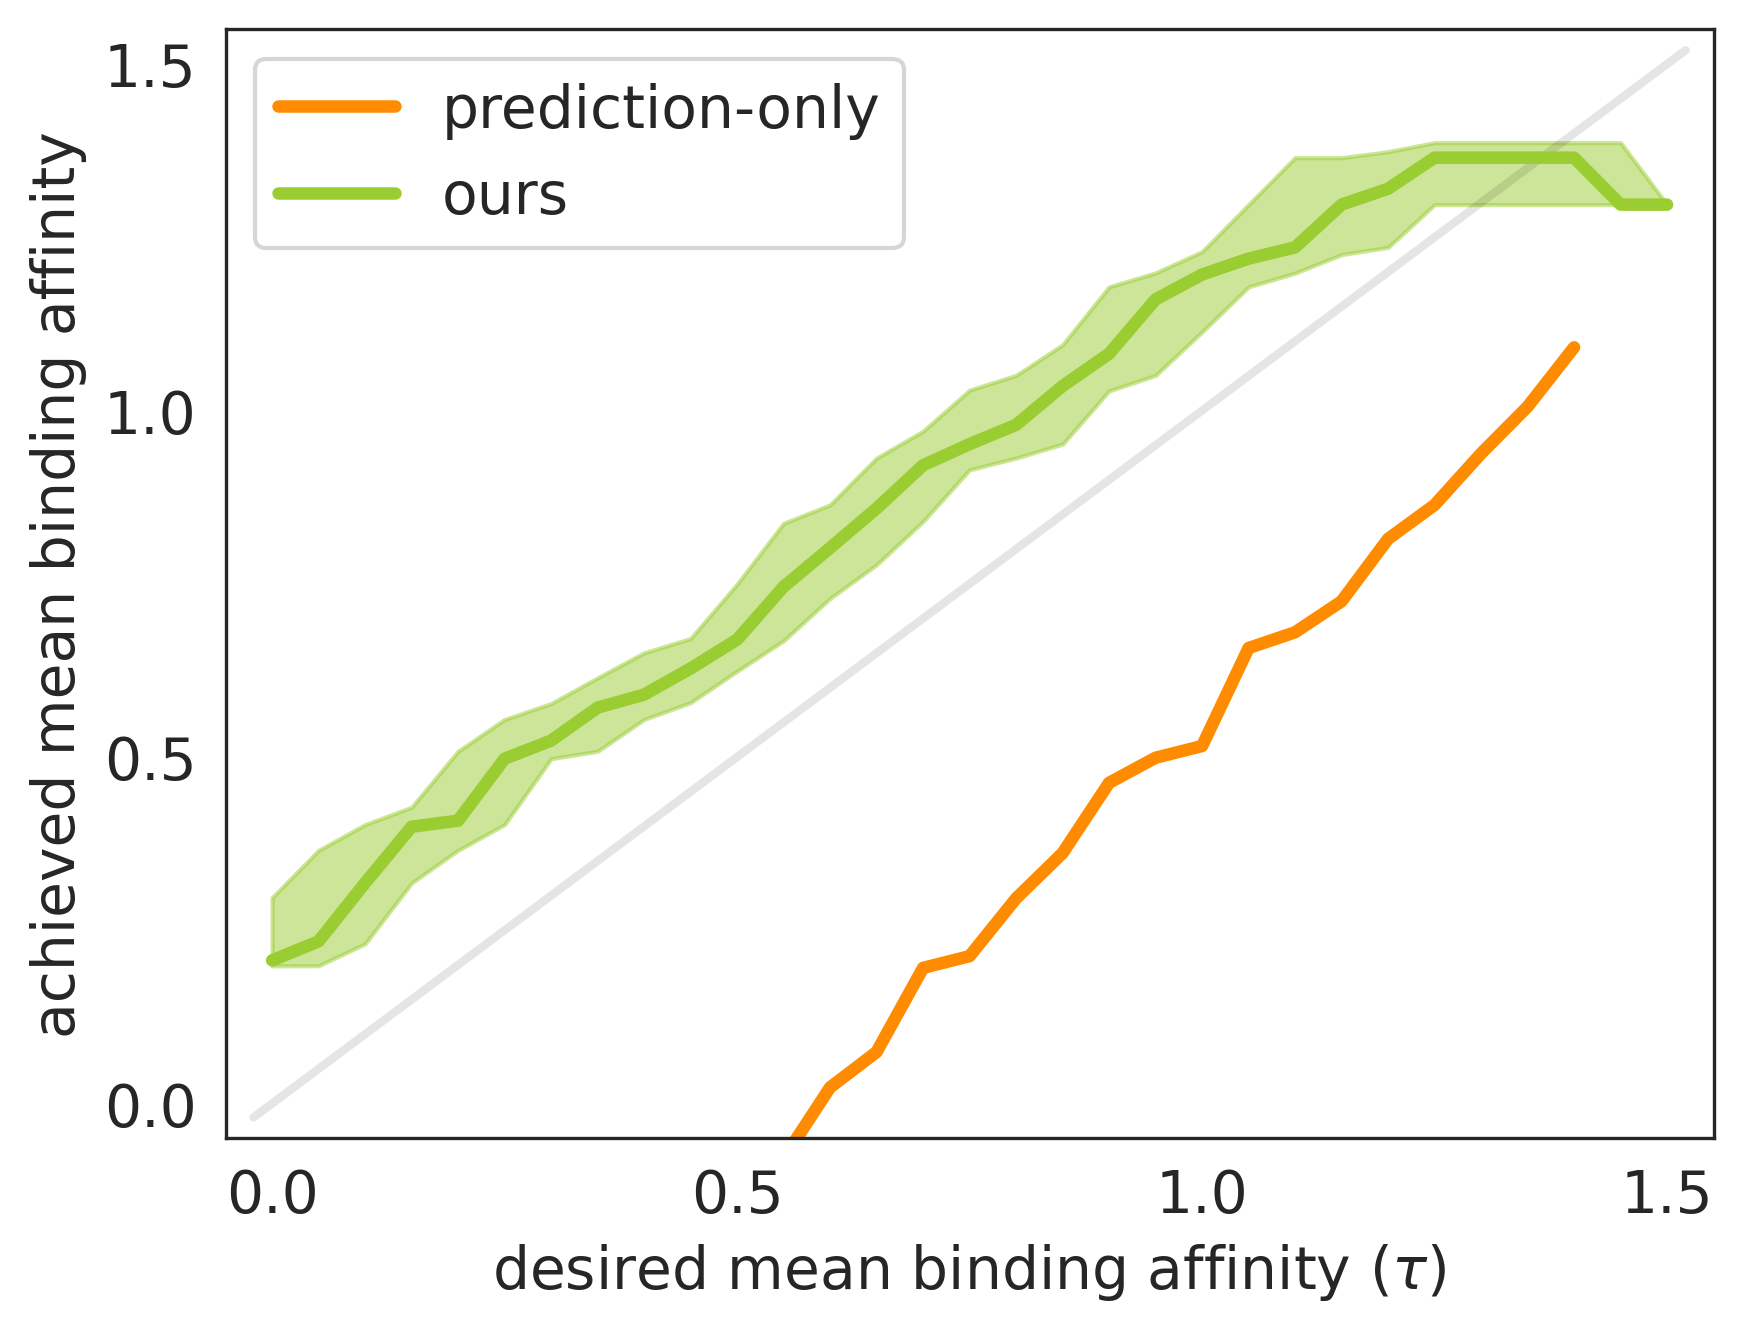

In [23]:
# demo figure for talks
sns.set_style('white')
alpha = 0.1
imp_color = 'darkorange'
pp_color = 'yellowgreen'
imp_xlim = [-0.05, 1.55]
imp_xticks = np.arange(0, 1.55, 0.5)
pp_xlim = [-0.05, 1.55]
pp_xticks = np.arange(0, 1.55, 0.5)

q_low = 0.2
q_high = 0.8

plt.figure(dpi=300)
plt.plot(
    [np.min(target_values) - 0.02, np.max(target_values) + 0.02],
    [np.min(target_values) - 0.02, np.max(target_values) + 0.02],
    '-k', alpha=0.1, linewidth=2
);
plt.plot(
    target_values, [np.median(worst) if len(worst) else np.nan for worst in impworst_v],
    c=imp_color, label='prediction-only', linewidth=3,
)
plt.fill_between(
    target_values, [np.quantile(worst, q_low) if len(worst) else np.nan for worst in impworst_v],
    [np.quantile(worst, q_high) if len(worst) else np.nan for worst in impworst_v],
    color=imp_color, alpha=0.5,
)
plt.plot(
    target_values, [np.median(worst) if len(worst) else np.nan for worst in ppworst_v],
    c=pp_color, label='ours', linewidth=3,
)
plt.fill_between(
    target_values, [np.quantile(worst, q_low) if len(worst) else np.nan for worst in ppworst_v],
    [np.quantile(worst, q_high) if len(worst) else np.nan for worst in ppworst_v],
    color=pp_color, alpha=0.5,
)

plt.ylabel('achieved mean binding affinity');
plt.xlabel(r'desired mean binding affinity ($\tau$)');
plt.xlim(imp_xlim);
plt.ylim(imp_xlim);
plt.xticks(imp_xticks);
plt.yticks(imp_xticks);
plt.legend();

## exceedance

In [28]:
imptemp2exceed = gb1.get_true_mean_label_from_theta(imptemp2theta, threshold=1.1)
pptemp2exceed = gb1.get_true_mean_label_from_theta(pptemp2theta, threshold=1.1) 

In [34]:
# load PP selection results, computed in gb1-022823 nb
reload(utils)
target_values = np.arange(0.0, 1., 0.02)
n_pp_trial = 500
pp_results_csv_fname = '/data/wongfanc/gb1-results/gb1-ncal8000_exceed1.1-tr3000_091924.csv'

pp_df = pd.read_csv(pp_results_csv_fname, index_col=0)
ppworst_v, pperr_v, ppdisc_v, ppval2temprange = utils.process_gb1_selection_experiments(
    pp_df, target_values, temperatures, pptemp2exceed, n_pp_trial, imp_or_pp='pp'
)

Processing pp results with 101 temperatures in [0.200, 0.700], 50 target values in [0.00, 0.98], 500 trials, and alpha = 0.1
Done processing (59 s)


In [94]:
# load imputation selection results, computed in gb1-imputation nb
target_values = np.arange(0.0, 1., 0.02)
n_imp_trial = 10
imp_results_csv_fname = '/data/wongfanc/gb1-results/gb1-imp-exceed1.1-092024.csv'

imp_df = pd.read_csv(imp_results_csv_fname, index_col=0)
impworst_v, imperr_v, impdisc_v, impval2temprange = utils.process_gb1_selection_experiments(
    imp_df, target_values, temperatures, imptemp2exceed, n_imp_trial, imp_or_pp='imp'
)

Processing imp results with 101 temperatures in [0.200, 0.700], 50 target values in [0.00, 0.98], 10 trials, and alpha = 0.1
Done processing (1 s)


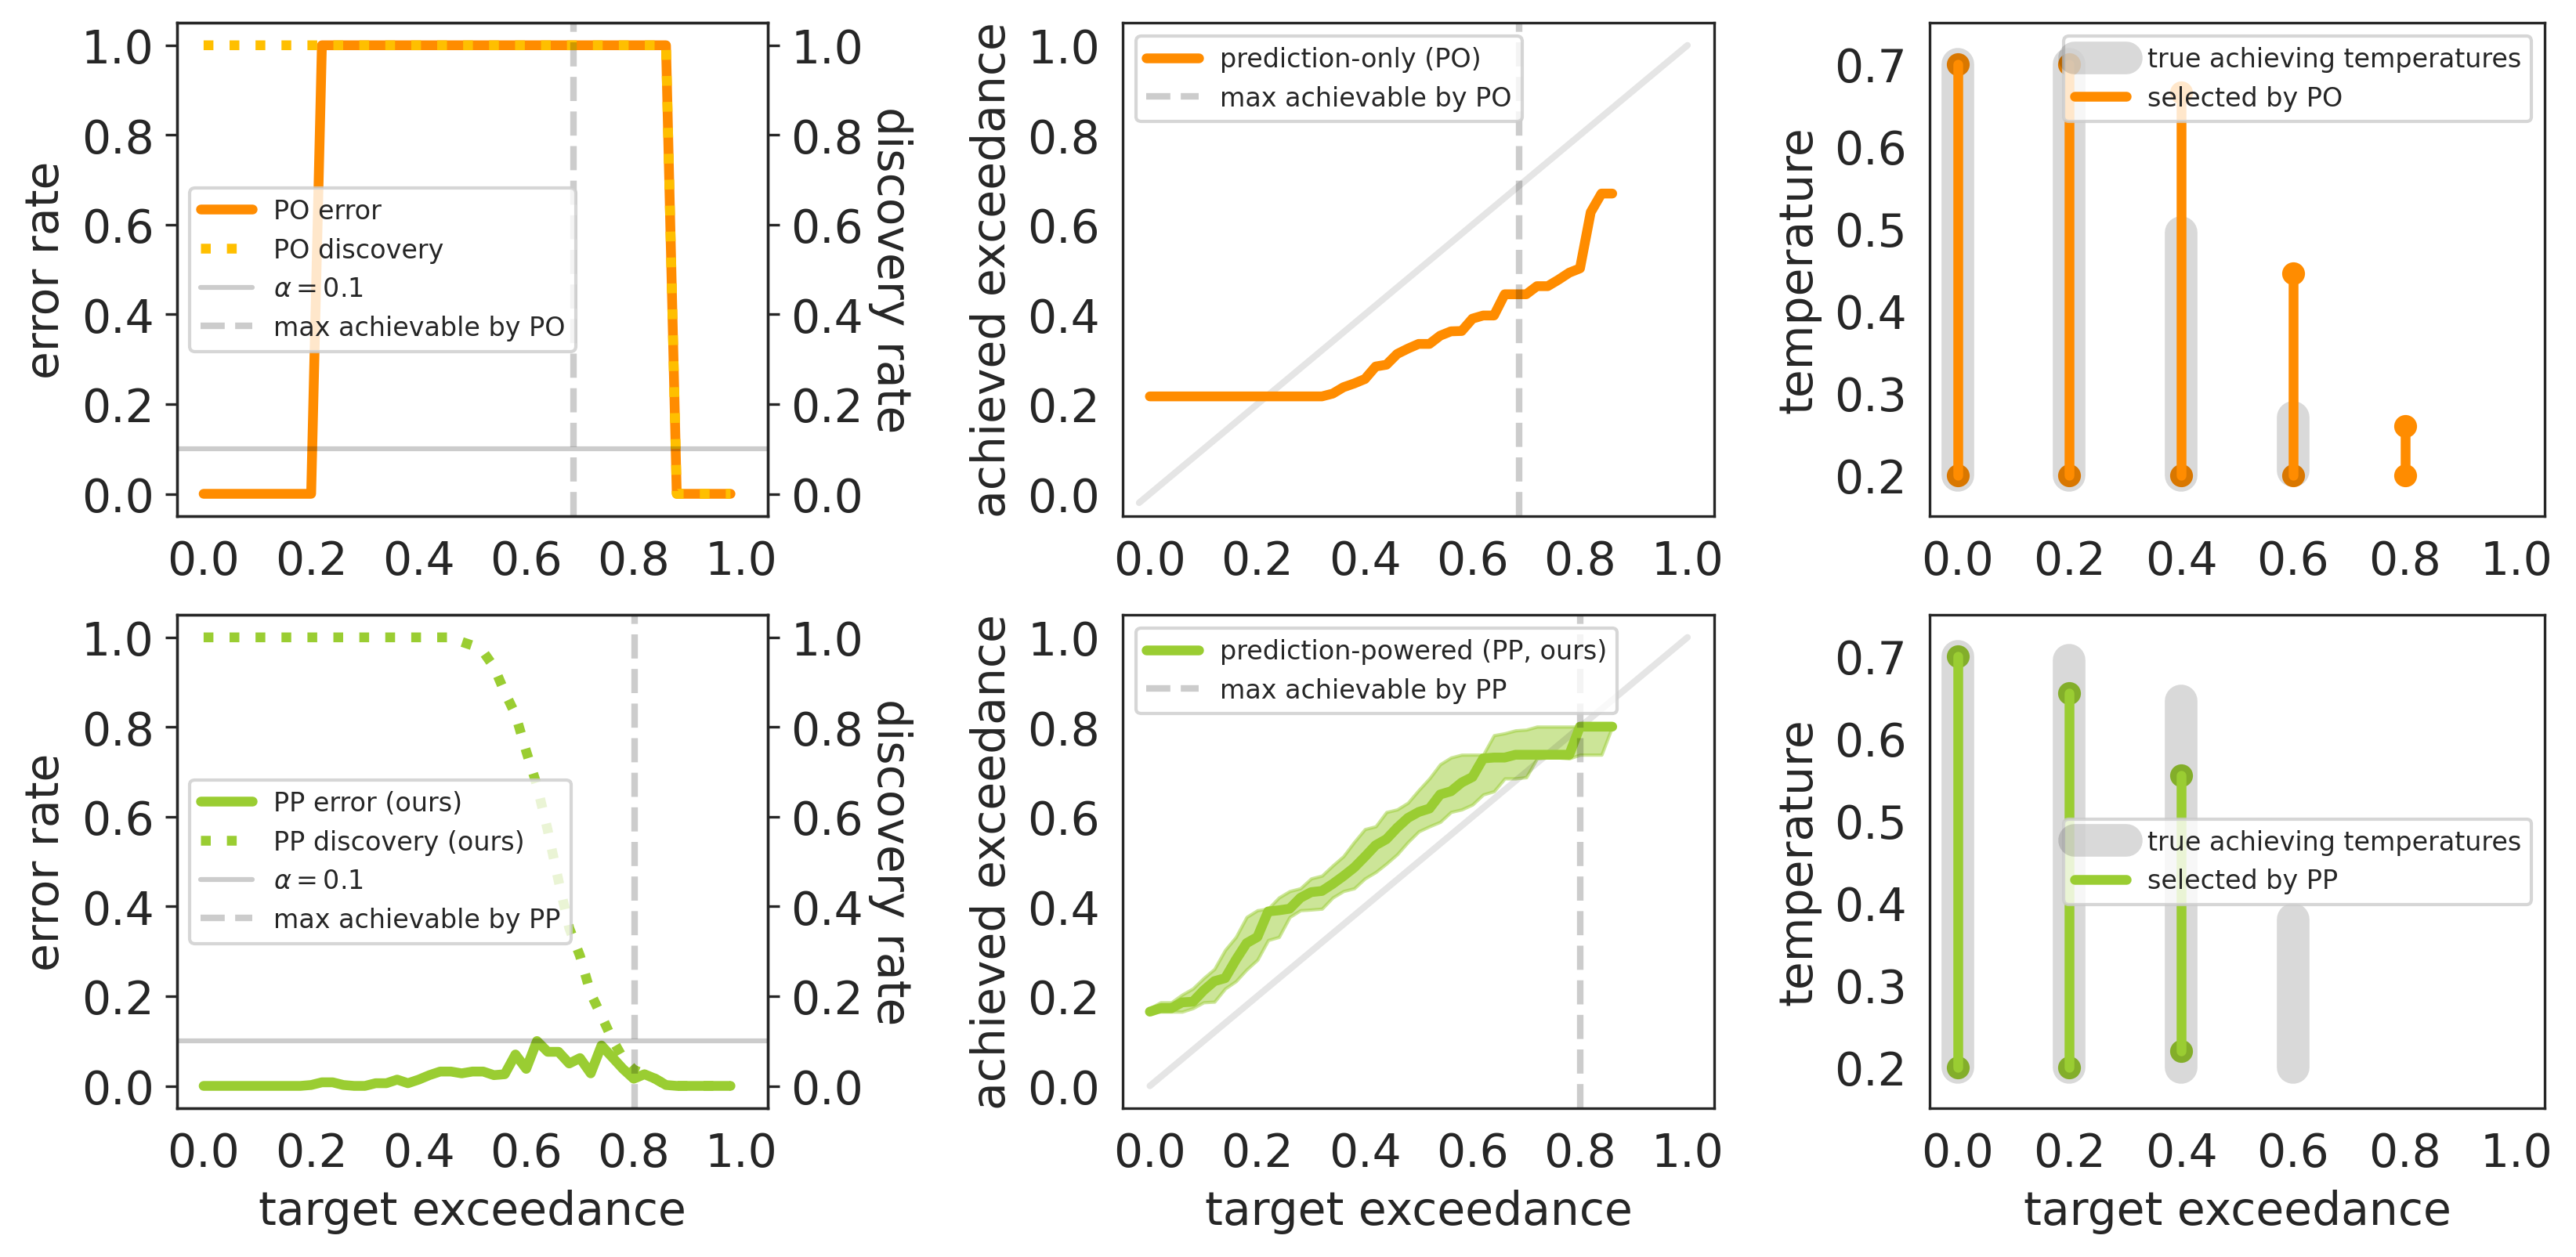

In [106]:
# plot two-row figure
fig = plt.figure(figsize=(13, 6), dpi=300)
outer = gridspec.GridSpec(1, 2, width_ratios = [2.5, 1], wspace=0.2)
gsleft = gridspec.GridSpecFromSubplotSpec(2, 2, subplot_spec = outer[0], wspace=0.6)
gsright = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec = outer[1])
ax00 = fig.add_subplot(gsleft[0, 0])
ax10 = fig.add_subplot(gsleft[1, 0])
ax01 = fig.add_subplot(gsleft[0, 1])
ax11 = fig.add_subplot(gsleft[1, 1])
ax02 = fig.add_subplot(gsright[0, 0])
ax12 = fig.add_subplot(gsright[1, 0])

alpha = 0.1
imp_color = 'darkorange'
pp_color = 'yellowgreen'

imp_max_achievable = np.max(list(imptemp2exceed.values()))
pp_max_achievable = np.max(list(pptemp2exceed.values()))

# ===== subplots (a, d) =====

ax00.set_ylabel('error rate');
ax00.set_ylim([-0.05, 1.05])
ax00.set_xticks(np.arange(np.min(target_values), np.max(target_values), 0.3))
ax00.set_yticks(np.arange(0, 1.1, 0.2))

disc_ax = ax00.twinx()
disc_ax.plot(target_values, imperr_v, c=imp_color, linewidth=3, label='PO error');
disc_ax.plot(target_values, impdisc_v, ':', c=(255/255, 191/255, 0), linewidth=3, label='PO discovery');
disc_ax.axhline(alpha, linestyle='-', color='k', alpha=0.2, linewidth=1.5, label=r'$\alpha = {}$'.format(alpha));
disc_ax.axvline(imp_max_achievable, linestyle='--', color='k', linewidth=2, alpha=0.2, label='max achievable by PO')
disc_ax.legend(fontsize=8)
disc_ax.set_ylabel('discovery rate', rotation=270, labelpad=15);
disc_ax.set_yticks(np.arange(0, 1.05, 0.2))
disc_ax.set_xticks(np.arange(0, 1.05, 0.2))
disc_ax.set_xlim([-0.05, 1.05])

ax10.set_ylabel('error rate');
ax10.set_xlabel('target exceedance');
ax10.set_ylim([-0.05, 1.05])
ax10.set_xticks(np.arange(0, 1.05, 0.2))
ax10.set_yticks(np.arange(0, 1.05, 0.2))

disc_ax = ax10.twinx()
disc_ax.plot(target_values, pperr_v, c=pp_color, linewidth=3, label='PP error (ours)');
disc_ax.plot(target_values, ppdisc_v, ':', c=pp_color, linewidth=3, label='PP discovery (ours)');
disc_ax.axhline(alpha, linestyle='-', color='k', alpha=0.2, linewidth=1.5, label=r'$\alpha = {}$'.format(alpha));
disc_ax.axvline(pp_max_achievable, linestyle='--', color='k', linewidth=2, alpha=0.2, label='max achievable by PP')
disc_ax.legend(fontsize=8)
disc_ax.set_ylabel('discovery rate', rotation=270, labelpad=15);
disc_ax.set_yticks(np.arange(0, 1.05, 0.2))
disc_ax.set_xticks(np.arange(0, 1.05, 0.2))
disc_ax.set_xlim([-0.05, 1.05])


# ===== subplots (b, e) =====

q_low = 0.2
q_high = 0.8

ax01.plot(
    [np.min(target_values) - 0.02, np.max(target_values) + 0.02],
    [np.min(target_values) - 0.02, np.max(target_values) + 0.02],
    '-k', alpha=0.1, linewidth=2
);
ax01.plot(
    target_values, [np.median(worst) if len(worst) else np.nan for worst in impworst_v],
    c=imp_color, label='prediction-only (PO)', linewidth=3,
)
ax01.fill_between(
    target_values, [np.quantile(worst, q_low) if len(worst) else np.nan for worst in impworst_v],
    [np.quantile(worst, q_high) if len(worst) else np.nan for worst in impworst_v],
    color=imp_color, alpha=0.5,
)
ax01.axvline(imp_max_achievable, linestyle='--', linewidth=2, color='k', alpha=0.2, label='max achievable by PO')
ax01.legend(fontsize=8)
ax01.set_ylabel('achieved exceedance');
ax01.set_xlim([-0.05, 1.05])
ax01.set_ylim([-0.05, 1.05])
ax01.set_xticks(np.arange(0, 1.05, 0.2))
ax01.set_yticks(np.arange(0, 1.05, 0.2))

ax11.plot([0, 1], [0, 1], '-k', alpha=0.1, linewidth=2)
ax11.plot(
    target_values, [np.median(worst) if len(worst) else np.nan for worst in ppworst_v],
    c=pp_color, label='prediction-powered (PP, ours)', linewidth=3,
)
ax11.fill_between(
    target_values, [np.quantile(worst, q_low) if len(worst) else np.nan for worst in ppworst_v],
    [np.quantile(worst, q_high) if len(worst) else np.nan for worst in ppworst_v],
    color=pp_color, alpha=0.5,
)
ax11.axvline(pp_max_achievable, linestyle='--', linewidth=2, color='k', alpha=0.2, label='max achievable by PP')
ax11.legend(fontsize=8)
ax11.set_xlabel('target exceedance');
ax11.set_ylabel('achieved exceedance');
ax11.set_xlim([-0.05, 1.05])
ax11.set_ylim([-0.05, 1.05])
ax11.set_xticks(np.arange(0, 1.05, 0.2))
ax11.set_yticks(np.arange(0, 1.05, 0.2))


# ===== subplots (c, f) =====

trial_idx = 0 # 100 # 25, 451 
example_targets = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]

for v, val in enumerate(example_targets):
    val = round(val, 4)
    
    imptruetemps = [t for t in temperatures if imptemp2exceed[round(t, 4)] >= val]
    if len(imptruetemps):
        ax02.plot([val, val], [np.min(imptruetemps), np.max(imptruetemps)],
                       c='k', alpha=0.15, linewidth=10, label='true achieving temperatures' if v == 0 else None)
    
    # plot temperature selected by imputation, if any
    if val in impval2temprange and len(impval2temprange[val][trial_idx]):
        ax02.plot([val, val], impval2temprange[val][trial_idx],
                       linewidth=3, c=imp_color, label='selected by PO' if v == 0 else None)
        ax02.scatter(
            [val, val], impval2temprange[val][trial_idx],
            marker='o', c=imp_color
        )
        
ax02.legend(fontsize=8)
ax02.set_ylim([0.15, 0.75])
ax02.set_ylabel('temperature');
ax02.set_xticks(np.arange(0, 1.05, 0.2))
ax02.set_yticks(np.arange(0.2, 0.71, 0.1))
ax02.set_xlim([-0.05, 1.05])

for v, val in enumerate(example_targets):
    val = round(val, 4)
    
    pptruetemps = [t for t in temperatures if pptemp2exceed[round(t, 4)] >= val]
    if len(pptruetemps):
        ax12.plot([val, val], [np.min(pptruetemps), np.max(pptruetemps)],
                       c='k', alpha=0.15, linewidth=10, label='true achieving temperatures' if v == 0 else None)
    
    # plot temperature selected by PP, if any
    if val in ppval2temprange and len(ppval2temprange[val][trial_idx]):
        ax12.plot([val, val], ppval2temprange[val][trial_idx],
                       linewidth=3, c=pp_color, label='selected by PP' if v == 0 else None)
        ax12.scatter([val, val], ppval2temprange[val][trial_idx],
                          marker='o', c=pp_color)
        
ax12.legend(fontsize=8)
ax12.set_ylim([0.15, 0.75])
ax12.set_ylabel('temperature');
ax12.set_xlabel('target exceedance');
ax12.set_xticks(example_targets)
ax12.set_yticks(np.arange(0.2, 0.71, 0.1))
ax12.set_xlim([-0.05, 1.05]);

# plt.savefig('../figures/gb1-.png')


# 01.15.25 sandbox

In [4]:
# load design distributions
temperatures = np.arange(0.2, 0.701, 0.005)

temp2theta = {
    round(temp, 4): np.load('/data/wongfanc/gb1-models/gb1-h10-10k-t{:.4f}-051324.npz'.format(temp))['theta_lxa']
    for temp in temperatures
}

In [7]:
for exceedance_threshold in [0.9, 0.7, 0.35]:
    temp2exceed = gb1.get_true_mean_label_from_theta(temp2theta, threshold=exceedance_threshold)
    with open('/data/wongfanc/gb1-models/h10-10k-051324-temp2exceed{}.pkl'.format(exceedance_threshold), 'wb') as f:
        pickle.dump(temp2exceed, f, protocol=pickle.HIGHEST_PROTOCOL)
        

In [11]:
# load and process results for plotting
exceedance_threshold = 0.9
target_values = np.arange(0.0, 1.01, 0.02)
n_trial = 10
gmm_forecast_qs = [0, 0.5, 1]

# load true exceedances
with open('/data/wongfanc/gb1-models/h10-10k-051324-temp2exceed{}.pkl'.format(exceedance_threshold), 'rb') as f:
    temp2exceed = pickle.load(f)

# load PO results
imp_csv_fname = '/data/wongfanc/gb1-results/gb1-imp-exceed{:.4f}-011425.csv'.format(exceedance_threshold)
imp_df = pd.read_csv(imp_csv_fname, index_col=0)
impworst_v, imperr_v, impdisc_v, impval2temprange = utils.process_gb1_selection_experiments(
    imp_df, target_values, temperatures, temp2exceed, n_trial, imp_or_pp='imp'
)

# load GMM forecast results
gmm_csv_fname = '/data/wongfanc/gb1-results/gb1-gmm-exceed{:.4f}-011425.csv'.format(exceedance_threshold)
temp_names = ['temp{:.4f}'.format(round(temp, 4)) for temp in temperatures]
name2trueexceed = {'temp{:.4f}'.format(round(temp, 4)): temp2exceed[round(temp, 4)] for temp in temperatures}
gmm_df = pd.read_csv(gmm_csv_fname, index_col=0)
gmm_type2results = utils.process_wheelock_selection_experiments(
    gmm_df, target_values, temp_names, name2trueexceed, n_trial, qs=gmm_forecast_qs
)

Processing imp results with 101 temperatures in [0.200, 0.700], 51 target values in [0.00, 1.00], 10 trials, and alpha = 0.1
Done processing (1 s)


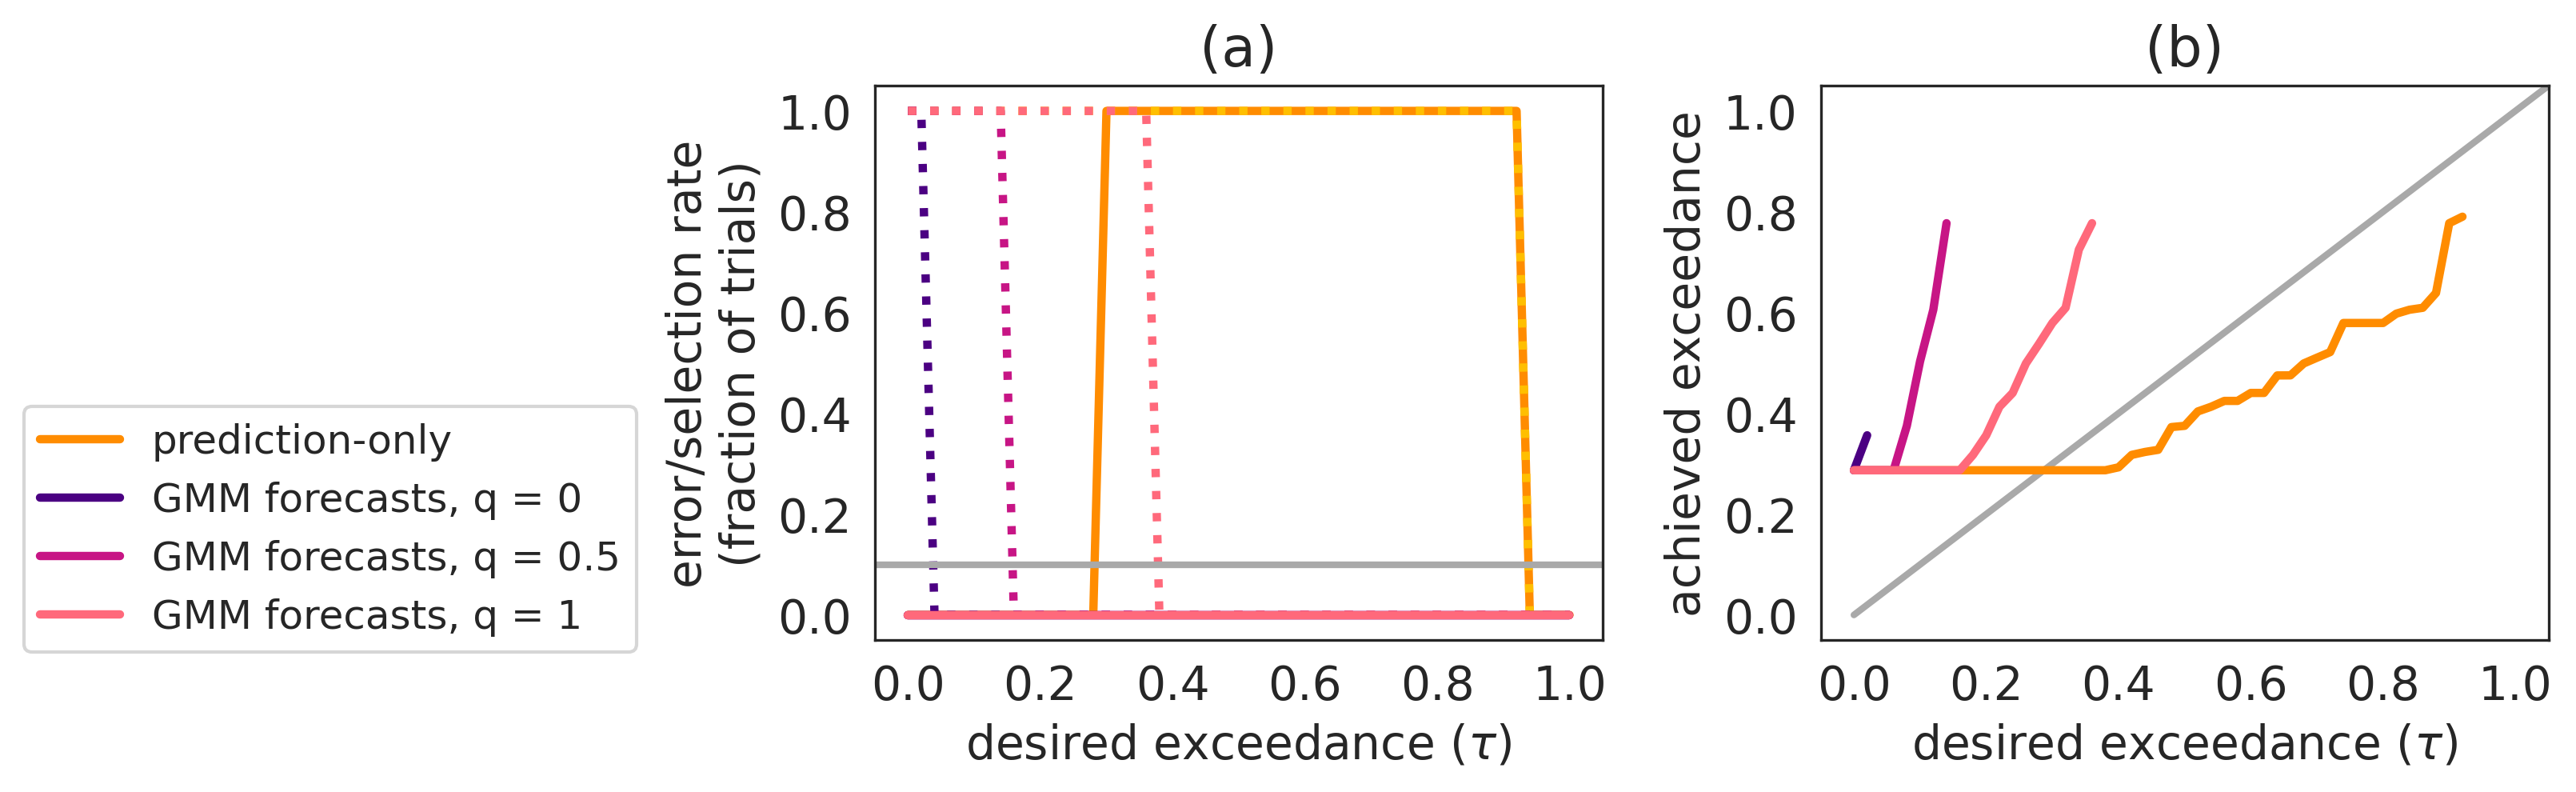

In [12]:
# one-row figure
fig, axs = plt.subplots(1, 2, figsize=(9, 3), dpi=300)
ax0 = axs[0]
ax1 = axs[1]
fig.subplots_adjust(wspace=0.3)

alpha = 0.1
gmm_type = 'cs'
imp_color = 'darkorange'
gmm_colors = ['indigo', 'mediumvioletred', '#ff697b']
dark_line_color = 'darkgray'

lw = 2.5
legend_fs = 12
imp_xlim = [-0.05, 1.05]
imp_xticks = np.arange(0, 1.01, 0.2)

q_low = 0.2
q_high = 0.8


# ===== subplot (a) =====
ax0.plot(target_values, imperr_v, c=imp_color, linewidth=lw);
ax0.plot(target_values, impdisc_v, ':', c=(255/255, 191/255, 0), linewidth=lw);

for q_idx, q in enumerate(gmm_forecast_qs):
    _, gmmerr_v, gmmdisc_v, _ = gmm_type2results[gmm_type][q]
    ax0.plot(target_values, gmmerr_v, c=gmm_colors[q_idx], linewidth=lw);
    ax0.plot(target_values, gmmdisc_v, ':', c=gmm_colors[q_idx], linewidth=lw);
    
ax0.axhline(alpha, linestyle='-', color=dark_line_color, alpha=1, linewidth=2, label=r'$\alpha = {}$'.format(alpha));

# dummy to get legend labels
ax0.plot(-1, -1, linestyle='-', color='k', linewidth=lw, label='error rate')
ax0.plot(-1, -1, linestyle=':', color='k', linewidth=lw, label='selection rate')

ax0.set_ylim([-0.05, 1.05])
ax0.set_yticks(np.arange(0, 1.05, 0.2))
ax0.set_xlim(imp_xlim)
ax0.set_xticks(imp_xticks)
ax0.set_ylabel('error/selection rate\n(fraction of trials)');
ax0.set_xlabel(r'desired exceedance ($\tau$)');
ax0.set_title('(a)');
# ax0.legend(fontsize=legend_fs, loc='center left', bbox_to_anchor=(-1.27, 0.8))
# ax0.legend(fontsize=legend_fs, loc='upper left', bbox_to_anchor=(0.0, 0.95))


# ===== subplot (b) =====

ax1.plot([0, 1.5], [0, 1.5], '-', c=dark_line_color, alpha=1, linewidth=2);
ax1.plot(
    target_values, [np.median(worst) if len(worst) else np.nan for worst in impworst_v],
    c=imp_color, label='prediction-only', linewidth=lw,
)
ax1.fill_between(
    target_values, [np.quantile(worst, q_low) if len(worst) else np.nan for worst in impworst_v],
    [np.quantile(worst, q_high) if len(worst) else np.nan for worst in impworst_v],
    color=imp_color, alpha=0.5,
)

for q_idx, q in enumerate(gmm_forecast_qs):
    gmmworst_v, _, _, _ = gmm_type2results[gmm_type][q]
    ax1.plot(
        target_values, [np.median(worst) if len(worst) else np.nan for worst in gmmworst_v],
        c=gmm_colors[q_idx], label=f'GMM forecasts, q = {q}', linewidth=lw,
    )
    ax1.fill_between(
        target_values, [np.quantile(worst, q_low) if len(worst) else np.nan for worst in gmmworst_v],
        [np.quantile(worst, q_high) if len(worst) else np.nan for worst in gmmworst_v],
        color=gmm_colors[q_idx], alpha=0.5,
    )

ax1.set_xlim(imp_xlim)
ax1.set_ylim(imp_xlim)
ax1.set_xticks(imp_xticks)
ax1.set_yticks(imp_xticks)
# ax1.legend(fontsize=legend_fs, loc='center left', bbox_to_anchor=(1.05, 0.5))
legend = ax1.legend(fontsize=legend_fs, loc='center right', bbox_to_anchor=(-1.6, 0.2))

ax1.set_title('(b)')
ax1.set_ylabel('achieved exceedance');
ax1.set_xlabel(r'desired exceedance ($\tau$)');


## PP

In [2]:
# load design distributions
temperatures = np.arange(0.2, 0.701, 0.005)
temp2theta = {
    round(t, 4): np.load('/data/wongfanc/gb1-models/gb1-h10-5k-t{:.4f}-030123.npz'.format(t))['theta_lxa']
    for t in temperatures
}

In [17]:
# only need to run once per threshold
exceedance_threshold = 0.7
temp2exceed = gb1.get_true_mean_label_from_theta(temp2theta, threshold=exceedance_threshold) 
with open('/data/wongfanc/gb1-models/h10-5k-030123-temp2exceed{}.pkl'.format(exceedance_threshold), 'wb') as f:
    pickle.dump(temp2exceed, f, protocol=pickle.HIGHEST_PROTOCOL)

In [4]:
# process results for plotting
exceedance_threshold = 0.7
n_trial = 200
target_values = np.arange(0.0, 1.01, 0.02)
pp_csv_fname = '/data/wongfanc/gb1-results/gb1-pp-exceed{:.4f}-011625.csv'.format(exceedance_threshold)
forecast_results_csv_fname = '/data/wongfanc/gb1-results/gb1-qc-exceed{:.4f}-011625.csv'.format(exceedance_threshold)

# load true exceedances 
with open('/data/wongfanc/gb1-models/h10-5k-030123-temp2exceed{}.pkl'.format(exceedance_threshold), 'rb') as f:
    temp2exceed = pickle.load(f)
    
pp_df = pd.read_csv(pp_csv_fname, index_col=0)
ppworst_v, pperr_v, ppdisc_v, ppval2temprange = utils.process_gb1_selection_experiments(
    pp_df, target_values, temperatures, temp2exceed, n_trial, imp_or_pp='pp'
)

forecast_df = pd.read_csv(forecast_results_csv_fname, index_col=0)
qcworst_v, qcerr_v, qcdisc_v = utils.process_gb1_cp_selection_experiments(
    forecast_df, target_values, temperatures, temp2exceed, n_trial
)

Processing pp results with 101 temperatures in [0.200, 0.700], 51 target values in [0.00, 1.00], 200 trials, and alpha = 0.1
Done processing (23 s)


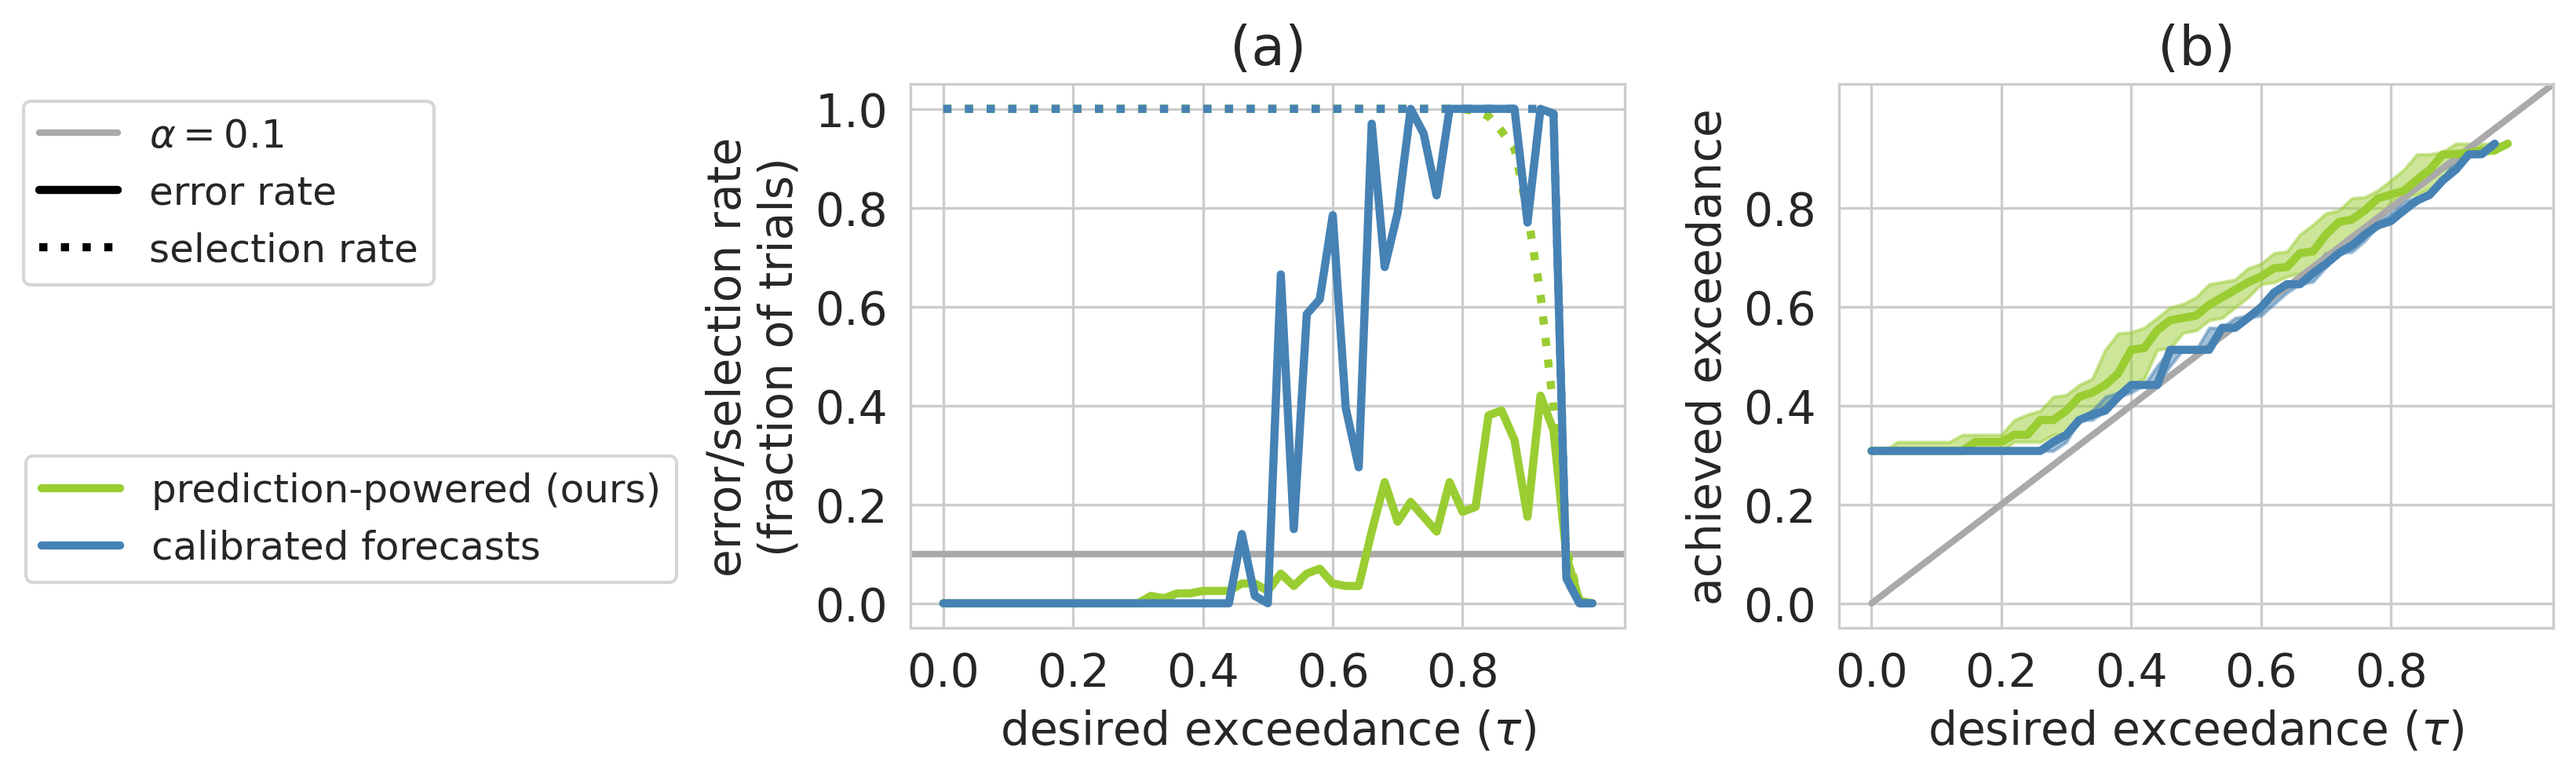

In [6]:
# one-row figure
sns.set_style('whitegrid')
fig, axs = plt.subplots(1, 2, figsize=(9, 3), dpi=300)
ax0 = axs[0]
ax1 = axs[1]
fig.subplots_adjust(wspace=0.3)

alpha = 0.1
pp_color = 'yellowgreen'
dark_line_color = 'darkgray'

lw = 2.5
legend_fs = 12
pp_xlim = [-0.05, 1.05]
pp_xticks = np.arange(0, 1., 0.2)

q_low = 0.2
q_high = 0.8


# ===== subplot (a) =====   
ax0.axhline(alpha, linestyle='-', color=dark_line_color, alpha=1, linewidth=2, label=r'$\alpha = {}$'.format(alpha));

ax0.plot(target_values, pperr_v, c=pp_color, linewidth=lw);
ax0.plot(target_values, ppdisc_v, ':', c=pp_color, linewidth=lw);

ax0.plot(target_values, qcerr_v, c='steelblue', linewidth=lw);
ax0.plot(target_values, qcdisc_v, ':', c='steelblue', linewidth=lw);

# dummy so get legend labels
ax0.plot(-1, -1, linestyle='-', color='k', linewidth=lw, label='error rate')
ax0.plot(-1, -1, linestyle=':', color='k', linewidth=lw, label='selection rate')

ax0.set_ylim([-0.05, 1.05])
ax0.set_yticks(np.arange(0, 1.05, 0.2))
ax0.set_xlim(pp_xlim)
ax0.set_xticks(pp_xticks)
ax0.set_ylabel('error/selection rate\n(fraction of trials)');
ax0.set_xlabel(r'desired exceedance ($\tau$)');
ax0.set_title('(a)')
ax0.legend(fontsize=legend_fs, loc='center left', bbox_to_anchor=(-1.27, 0.8))


# ===== subplot (b) =====

ax1.plot([0, 1.5], [0, 1.5], '-', c=dark_line_color, alpha=1, linewidth=2);

ax1.plot(
    target_values, [np.median(worst) if len(worst) else np.nan for worst in ppworst_v],
    c=pp_color, label='prediction-powered (ours)', linewidth=lw,
)
ax1.fill_between(
    target_values, [np.quantile(worst, q_low) if len(worst) else np.nan for worst in ppworst_v],
    [np.quantile(worst, q_high) if len(worst) else np.nan for worst in ppworst_v],
    color=pp_color, alpha=0.5,
)

ax1.plot(
    target_values, [np.median(worst) if len(worst) else np.nan for worst in qcworst_v],
    c='steelblue', label='calibrated forecasts', linewidth=lw,
)
ax1.fill_between(
    target_values, [np.quantile(worst, q_low) if len(worst) else np.nan for worst in qcworst_v],
    [np.quantile(worst, q_high) if len(worst) else np.nan for worst in qcworst_v],
    color='steelblue', alpha=0.5,
)

ax1.set_xlim(pp_xlim)
ax1.set_ylim(pp_xlim)
ax1.set_xticks(pp_xticks)
ax1.set_yticks(pp_xticks)
legend = ax1.legend(fontsize=legend_fs, loc='center right', bbox_to_anchor=(-1.6, 0.2))

ax1.set_title('(b)')
ax1.set_ylabel('achieved exceedance');
ax1.set_xlabel(r'desired exceedance ($\tau$)');
